In [1]:
import os

# os.environ['LD_LIBRARY_PATH'] = os.environ.get('LD_LIBRARY_PATH', '') + ':/home/drhead/miniconda3/envs/sam_hq_xla/lib:/usr/local/cuda/targets/x86_64-linux/lib'
os.environ['PT_XLA_DEBUG'] = '1' 
os.environ['PT_XLA_DEBUG_FILE'] = './xla_debug.txt'
os.environ['PJRT_DEVICE'] = 'TPU'

# Nonzero op lowering is unstable but seems to work for some ops
# os.environ['XLA_EXPERIMENTAL'] = 'nonzero'

# Will cast torch.float and torch.double to BF16
os.environ['XLA_USE_BF16'] = '1'

os.environ['XLA_EMIT_STEPLOG'] = '1'
# Will cast torch.float to BF16 and torch.double to float32
# os.environ['XLA_DOWNCAST_BF16'] = '1'
os.environ['XLA_IR_DEBUG'] = '1'
os.environ['XLA_HLO_DEBUG'] = '1'
os.environ['MASTER_PORT'] = '29500'

import numpy as np
import torch
print("PyTorch version:", torch.__version__)
import torch_xla.core.xla_model as xm

import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
import torch.distributed as dist
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_backend
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.experimental.pjrt_backend
import torch_xla.experimental.pjrt as pjrt
import matplotlib.pyplot as plt
import cv2
import time

import torch_xla.debug.profiler as xp
import torch_xla.utils.utils as xu
import multiprocessing

# !git clone -b xla https://github.com/drhead/sam-hq.git
# os.chdir('sam-hq')
# !export PYTHONPATH=$(pwd)
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

PyTorch version: 2.0.0a0+gitc263bd4


In [2]:
#!mkdir pretrained_checkpoint
#!wget https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_h.pth
#!mv sam_hq_vit_h.pth pretrained_checkpoint


In [3]:
def show_anns(anns, valid_masks):
    if len(anns) == 0:
        return

    valid_anns = anns[valid_masks]  # Filter out invalid masks
    if len(valid_anns) == 0:
        return
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((valid_anns[0].shape[0], valid_anns[0].shape[1], 4))
    img[:,:,3] = 0
    for ann in valid_anns:
        m = ann.cpu()
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

(512, 512, 3)


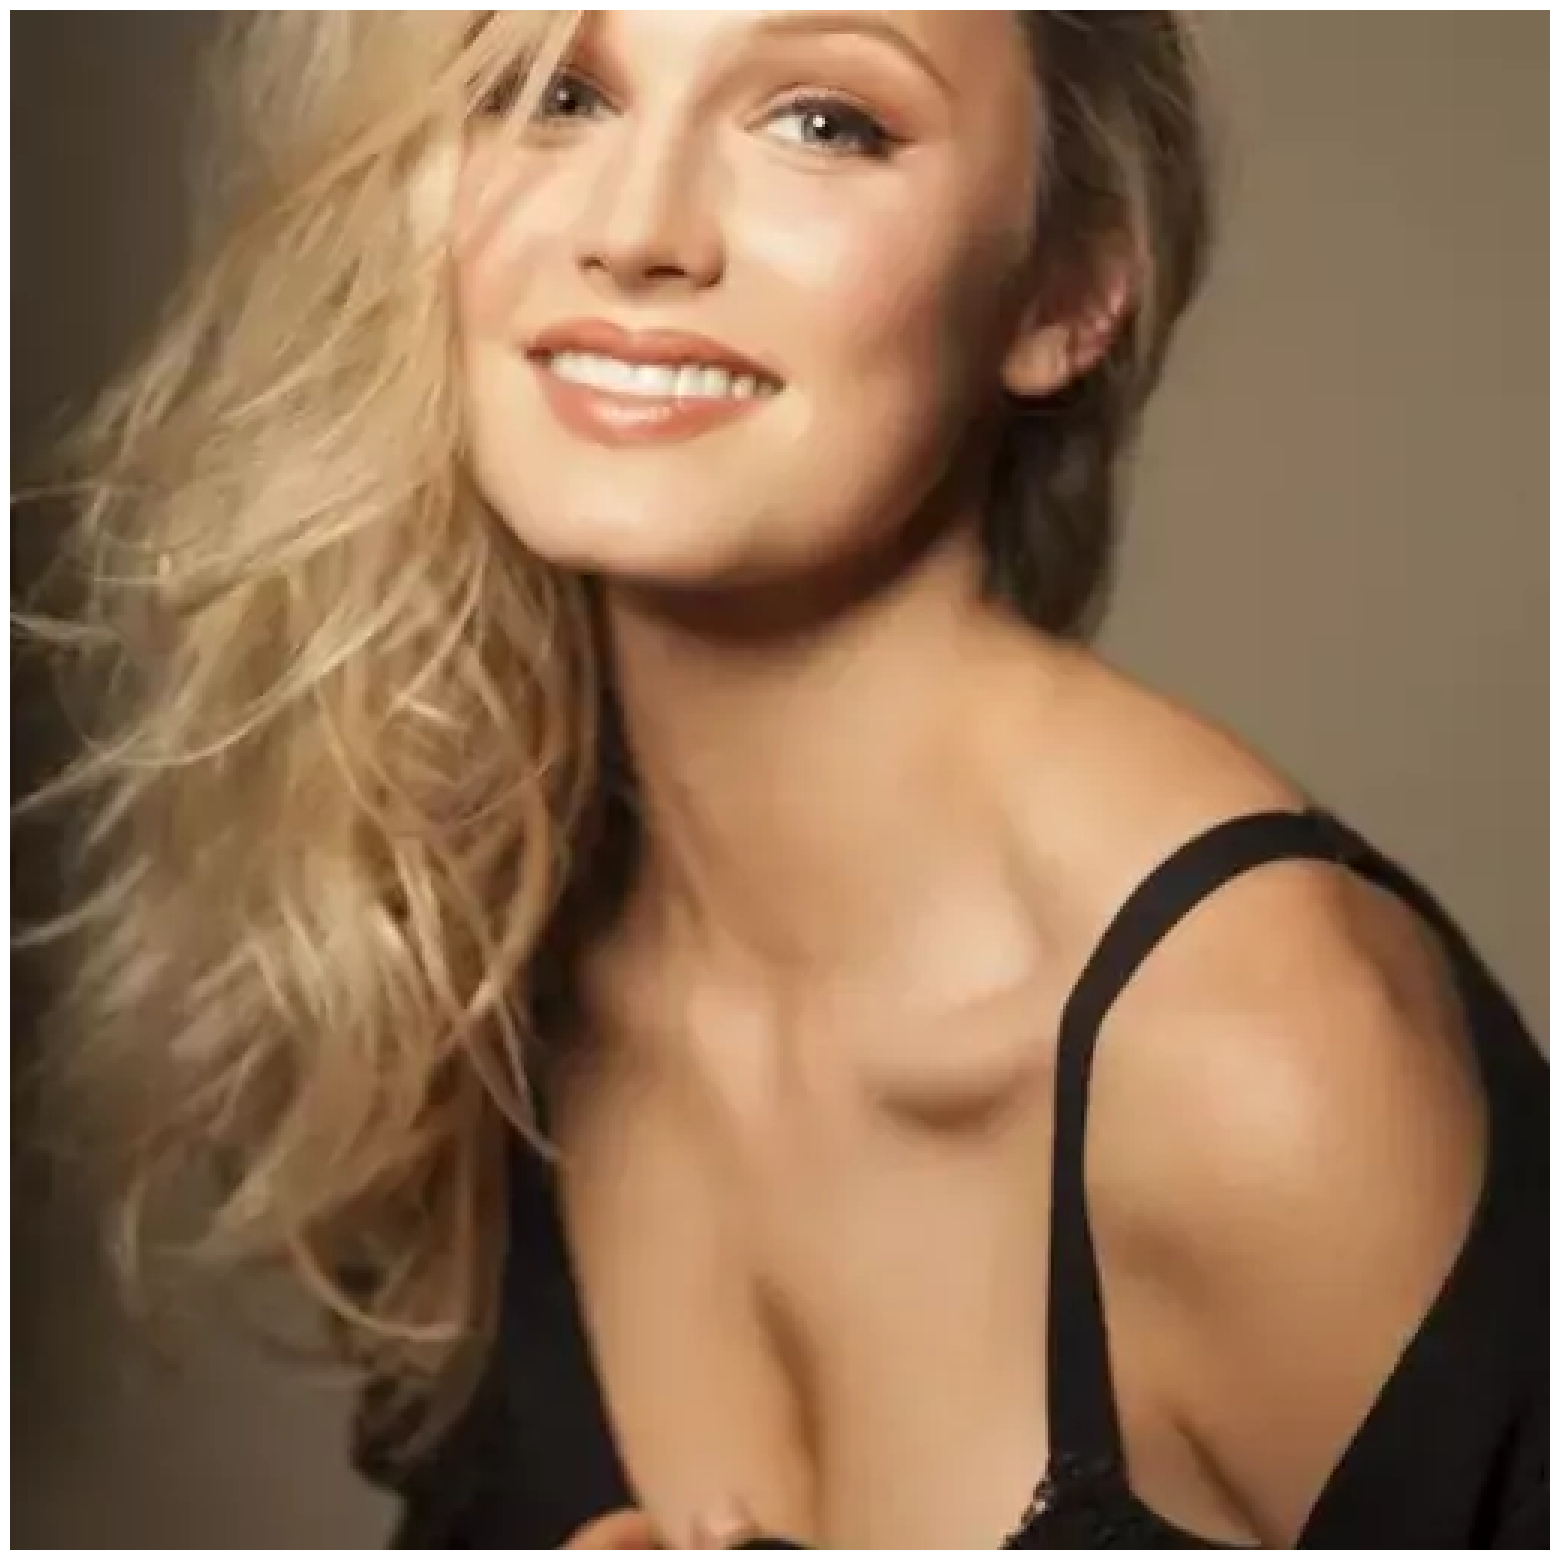

In [4]:
# image = cv2.imread('data/zd_testimgs/-663378304158021540.webp')
image = cv2.imread('data/zd_testimgs/-15714488383694269.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [5]:
""" from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.file_list = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_list[idx])
        image = cv2.imread(img_path)
        print(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image
    
data_directory = "./data/zd_testimgs/"
dataset = CustomImageDataset(data_directory)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0) """

' from torch.utils.data import Dataset, DataLoader\n\nclass CustomImageDataset(Dataset):\n    def __init__(self, img_dir, transform=None):\n        self.img_dir = img_dir\n        self.transform = transform\n        self.file_list = os.listdir(self.img_dir)\n\n    def __len__(self):\n        return len(self.file_list)\n\n    def __getitem__(self, idx):\n        img_path = os.path.join(self.img_dir, self.file_list[idx])\n        image = cv2.imread(img_path)\n        print(img_path)\n        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)\n        if self.transform:\n            image = self.transform(image)\n        return image\n    \ndata_directory = "./data/zd_testimgs/"\ndataset = CustomImageDataset(data_directory)\ndataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0) '

In [6]:
sam_checkpoint = "pretrained_checkpoint/sam_hq_vit_h.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
model = sam.to(xm.xla_device())
model.eval()
sam_dynamo = torch.compile(model, backend='torchxla_trace_once')

mask_generator = SamAutomaticMaskGenerator(
    model=sam_dynamo,
    points_per_side=4,
    points_per_batch=16
)

<All keys matched successfully>


In [7]:
def gen_masks():
    xp.trace('localhost:6009', logdir='/home/lodestone/sam-hq/', num_tracing_attempts=1, host_tracer_level=3, timeout_s=15, duration_ms=10000)
    print('Done tracing')
trace = False
if trace:
    p = multiprocessing.Process(target=gen_masks)
    p.start()
    server = xp.start_server(6009)
    time.sleep(5)

masks, valid = mask_generator.generate(torch.as_tensor(image).permute(2, 0, 1).contiguous()[None, :, :, :], multimask_output=False)
print(f"got {valid.count_nonzero()} masks")
print(valid)

torch_xla.core.xla_model::mark_step


got 2 masks
tensor([ True,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False], device='xla:0')


In [8]:
print(masks.shape)

torch.Size([16, 512, 512])


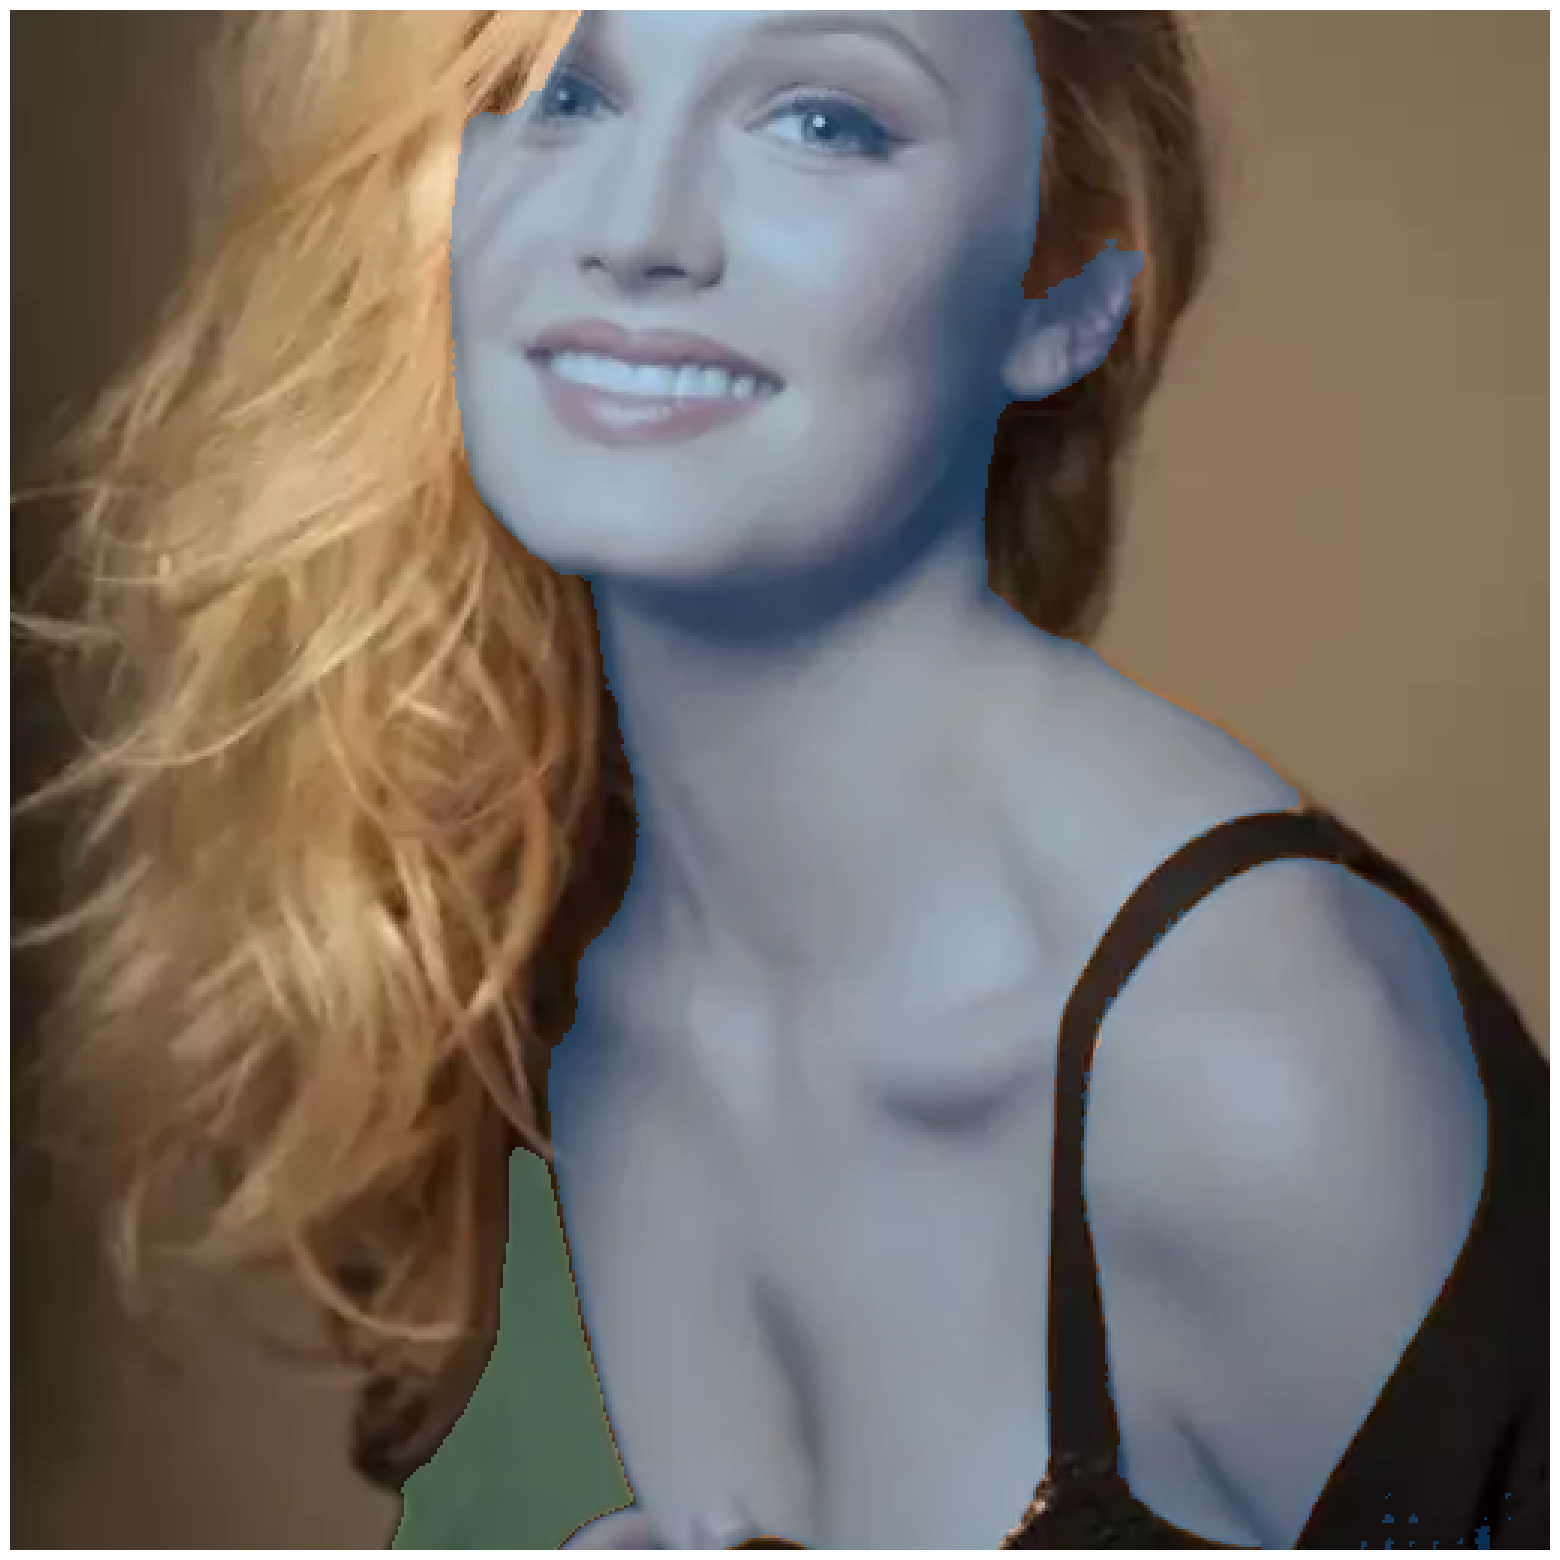

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks, valid)
plt.axis('off')
plt.show()

In [10]:
import torch_xla.debug.metrics as met
print(met.metrics_report())
met.clear_all()

Metric: DeviceLockWait
  TotalSamples: 14
  Accumulator: 527.790us
  ValueRate: 289.296us / second
  Rate: 7.67378 / second
  Percentiles: 1%=001.473us; 5%=001.473us; 10%=001.740us; 20%=001.986us; 50%=006.690us; 80%=010.510us; 90%=011.033us; 95%=454.500us; 99%=454.500us
Metric: InputOutputAliasCount
  TotalSamples: 1
  Accumulator: 621.00
  Percentiles: 1%=621.00; 5%=621.00; 10%=621.00; 20%=621.00; 50%=621.00; 80%=621.00; 90%=621.00; 95%=621.00; 99%=621.00
Metric: IrValueTensorToXlaData
  TotalSamples: 692
  Accumulator: 01s465ms525.491us
  ValueRate: 037ms869.959us / second
  Rate: 17.4214 / second
  Percentiles: 1%=024.766us; 5%=029.121us; 10%=031.956us; 20%=035.110us; 50%=058.277us; 80%=363.735us; 90%=008ms404.799us; 95%=018ms025.997us; 99%=018ms300.587us
Metric: TensorToData
  TotalSamples: 712
  Accumulator: 01s464ms810.196us
  ValueRate: 037ms851.716us / second
  Rate: 17.9247 / second
  Percentiles: 1%=023.538us; 5%=027.838us; 10%=030.504us; 20%=033.713us; 50%=055.101us; 80%=266